<a href="https://colab.research.google.com/github/TurkuNLP/textual-data-analysis-course/blob/main/text_classification_basic_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic supervised text classification

Let's train a basic supervised text classification model.

---

## Setup

Install the required Python packages:

In [1]:
!pip install --quiet transformers datasets evaluate

Import the libraries we'll be using here.

In [2]:
import datasets
import transformers
import evaluate

from pprint import pprint

Make things a bit more quiet. (This only affects what shows on screen when running. If you're debugging, you probably want to comment these out.)

In [3]:
transformers.utils.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()
datasets.disable_progress_bar()

---

## Load dataset

Load a dataset for training using `datasets`.

In [4]:
DATASET = 'emotion'

builder = datasets.load_dataset_builder(DATASET)
dataset = datasets.load_dataset(DATASET)

Let's have a look at the description and dataset.

In [5]:
print(builder.info.description)

Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper.



In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Take note of the number of different labels and create mappings from label IDs to label strings and vice versa; we'll need these later.

In [7]:
label_names = dataset['train'].features['label'].names
print('Labels:', label_names)

num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

print('Number of labels:', num_labels)
print('id2label mapping:', id2label)
print('labelid2 mapping:', label2id)

Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Number of labels: 6
id2label mapping: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
labelid2 mapping: {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}


---

## Tokenize and vectorize dataset

(This should be familiar to you from the deep learning course. If you need a refresher, see https://moodle.utu.fi/course/view.php?id=24036 .)

First, we'll load the tokenizer that corresponds to the model that we want to use. `AutoTokenizer` is a convenience class that will return the appropriate tokenizer for the model it's given as an argument:

In [8]:
MODEL = 'bert-base-cased'

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

The tokenizer will, most importantly, produce `input_ids`, which identify the tokens of the text.

The BERT tokenizer also produces an `attention_mask`, which can be used to make the model ignore some tokens, and `token_type_ids`, which can differentiate parts of the input e.g. when it consists of two separate texts.

In [9]:
pprint(tokenizer('this is an example sentence'))

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 1142, 1110, 1126, 1859, 5650, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


We'll then apply the tokenizer to the whole dataset. The primary role of the `tokenize` function we define here is to identify the field of the data that should be tokenized.

In [10]:
def tokenize(example):
  return tokenizer(example['text'])

dataset = dataset.map(tokenize)

**NOTE**: perhaps unintuitively, `dataset = dataset.map(tokenize)` does _not_ replace `text` and `label` with `input_ids` etc., but rather adds to them:

In [11]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})


---

## Instantiate model

Now, we'll instantiate a pretrained model with a text classification head. In the `transformers` library, this class of models are named `...ModelForSequenceClassification`. We'll again use the `Auto` variant to get the appropriate class based on model name.

**NOTE**: we need to provide the number of labels to `from_pretrained` so that the function knows the size of the output layer that is required. The `id2label` and `label2id` mappings allow the model to report its classification results in interpretable text labels.

In [12]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

---

## Training configuration

To assess the progress and results of training, we'll use the standard `accuracy` metric. We'll also need to introduce a simple function that takes model outputs and the labels from the dataset and calls the metric:

In [13]:
accuracy = evaluate.load('accuracy')

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) # pick index of "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

The `TrainingArguments` class configures many of the details of the model training. You may want to try optimizing the following hyperparameters to improve model performance:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per training batch
* `max_steps`: the maximum number of steps to train for

In [14]:
trainer_args = transformers.TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=1000,
)

Finally, we'll create a custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [15]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

---

## Train (fine-tune) model

In [16]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_accuracy,
    tokenizer=tokenizer,
    callbacks=[training_logs], 
)

max_steps is given, it will override any value given in num_train_epochs


In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 108314886
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method

{'loss': 1.6033, 'learning_rate': 9e-06, 'epoch': 0.05}
{'eval_loss': 1.477716088294983, 'eval_accuracy': 0.48, 'eval_runtime': 5.5152, 'eval_samples_per_second': 362.637, 'eval_steps_per_second': 11.423, 'epoch': 0.05}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 1.265, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.1}
{'eval_loss': 1.1896827220916748, 'eval_accuracy': 0.5655, 'eval_runtime': 5.6916, 'eval_samples_per_second': 351.394, 'eval_steps_per_second': 11.069, 'epoch': 0.1}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 1.0274, 'learning_rate': 7e-06, 'epoch': 0.15}
{'eval_loss': 0.7903162837028503, 'eval_accuracy': 0.7475, 'eval_runtime': 5.7655, 'eval_samples_per_second': 346.892, 'eval_steps_per_second': 10.927, 'epoch': 0.15}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.8197, 'learning_rate': 6e-06, 'epoch': 0.2}
{'eval_loss': 0.663108229637146, 'eval_accuracy': 0.775, 'eval_runtime': 5.9531, 'eval_samples_per_second': 335.961, 'eval_steps_per_second': 10.583, 'epoch': 0.2}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.65, 'learning_rate': 5e-06, 'epoch': 0.25}


Saving model checkpoint to checkpoints/checkpoint-500
Configuration saved in checkpoints/checkpoint-500/config.json


{'eval_loss': 0.5618837475776672, 'eval_accuracy': 0.808, 'eval_runtime': 6.0859, 'eval_samples_per_second': 328.627, 'eval_steps_per_second': 10.352, 'epoch': 0.25}


Model weights saved in checkpoints/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.5792, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.3}
{'eval_loss': 0.4926503896713257, 'eval_accuracy': 0.8505, 'eval_runtime': 6.1162, 'eval_samples_per_second': 327.0, 'eval_steps_per_second': 10.301, 'epoch': 0.3}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.5369, 'learning_rate': 3e-06, 'epoch': 0.35}
{'eval_loss': 0.45740213990211487, 'eval_accuracy': 0.8515, 'eval_runtime': 6.3271, 'eval_samples_per_second': 316.1, 'eval_steps_per_second': 9.957, 'epoch': 0.35}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.4701, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.4}
{'eval_loss': 0.43556466698646545, 'eval_accuracy': 0.87, 'eval_runtime': 6.3948, 'eval_samples_per_second': 312.754, 'eval_steps_per_second': 9.852, 'epoch': 0.4}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.4477, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.45}
{'eval_loss': 0.4059715270996094, 'eval_accuracy': 0.8775, 'eval_runtime': 6.3123, 'eval_samples_per_second': 316.841, 'eval_steps_per_second': 9.98, 'epoch': 0.45}


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'loss': 0.4842, 'learning_rate': 0.0, 'epoch': 0.5}


Saving model checkpoint to checkpoints/checkpoint-1000
Configuration saved in checkpoints/checkpoint-1000/config.json


{'eval_loss': 0.4024040400981903, 'eval_accuracy': 0.88, 'eval_runtime': 6.2187, 'eval_samples_per_second': 321.612, 'eval_steps_per_second': 10.131, 'epoch': 0.5}


Model weights saved in checkpoints/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-1000/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from checkpoints/checkpoint-1000 (score: 0.4024040400981903).


{'train_runtime': 173.2209, 'train_samples_per_second': 46.184, 'train_steps_per_second': 5.773, 'train_loss': 0.788350399017334, 'epoch': 0.5}


TrainOutput(global_step=1000, training_loss=0.788350399017334, metrics={'train_runtime': 173.2209, 'train_samples_per_second': 46.184, 'train_steps_per_second': 5.773, 'train_loss': 0.788350399017334, 'epoch': 0.5})

---

## Evaluate trained model

We can use the `trainer` to evaluate the trained model using the metric we defined:

In [18]:
eval_results = trainer.evaluate(dataset['test'])

pprint(eval_results)

print('\nAccuracy:', eval_results['eval_accuracy'])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'eval_loss': 0.39968162775039673, 'eval_accuracy': 0.8825, 'eval_runtime': 6.282, 'eval_samples_per_second': 318.37, 'eval_steps_per_second': 10.029, 'epoch': 0.5}
{'epoch': 0.5,
 'eval_accuracy': 0.8825,
 'eval_loss': 0.39968162775039673,
 'eval_runtime': 6.282,
 'eval_samples_per_second': 318.37,
 'eval_steps_per_second': 10.029}

Accuracy: 0.8825


As we captured performance during training using the `training_logs` callback, we can also have a look at training and evaluation loss and evaluation accuracy progression. (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

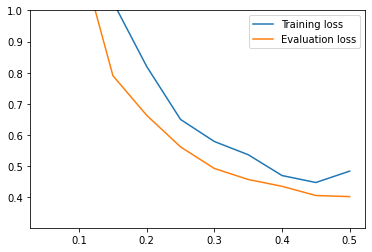

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'])

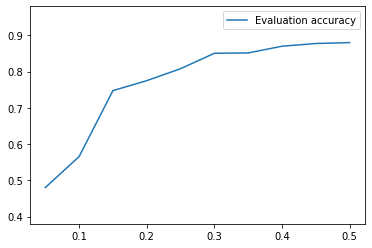

In [20]:
plot(training_logs.logs, ['eval_accuracy'], ['Evaluation accuracy'])

---

## Create pipeline



We can wrap our fine-tuned model in a pipeline for convenience. (We need to specify `device` here as the model is on GPU.)

In [21]:
pipe = transformers.pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    device=0
)

We can then use the pipeline simply as follows:

In [22]:
pipe('Wow, this is great!')

[{'label': 'joy', 'score': 0.9298135638237}]

In [23]:
pipe("I'm not sure if this model is any good, though.")

[{'label': 'joy', 'score': 0.7576267123222351}]

In [24]:
pipe('That is quite unfortunate.')

[{'label': 'sadness', 'score': 0.8481240272521973}]

Can you make the model better?